In [2]:
import requests
import pickle
import pandas as pd
import json as js
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.cluster import KMeans
from matplotlib.dates import DateFormatter, date2num
import plotly.express as px
import math
#import matplotlib.lines as mlines

In [96]:
players_df = pd.concat(map(pd.read_csv, ['players_df_500.csv', 'players_df_1082.csv']))
teams_df = pd.concat(map(pd.read_csv, ['teams_df_500.csv', 'teams_df_1082.csv']))
teams_df = teams_df.drop_duplicates()
teams_df = teams_df.sort_values('id')
games_df = pd.concat(map(pd.read_csv, ['games_df_500.csv', 'games_df_1082.csv']))
#events_df = pd.read_csv('events_df.csv')
#players_df
#teams_df
#games_df

In [1319]:
events_df = pd.concat(map(pd.read_csv, ['events_df_500.csv', 'events_df_1082.csv']))

In [1320]:
#EVENTS_DF cicomazas
#Nullas sorok feltoltese hogy utana int-re valtoztathassuk
events_df = events_df.fillna(0)
events_df = events_df.astype({'player1Id': 'int64','player2Id':'int64','player3Id':'int64','player4Id':'int64',
                              'coX': 'int64','coY':'int64'})

In [1321]:
#Distinct jatek datumok uj dataframeben mert az elejen elfelejtettem belevenni a read api-ba
date_df =  games_df.loc[:,['pk','startDate']]
#Ramergeljuk az events_df-re
events_df = pd.merge(left=events_df, right=date_df, left_on='gameId', right_on='pk', how='left')
events_df = events_df.drop(columns=['pk'])
#A datum vegerol levagjuk a felesleges reszt hogy szep legyen
events_df['startDate'] = events_df['startDate'].str[:10]

In [1329]:
#A periodTime konvertalasa Timedelta tipusra
events_df['periodTimeFull'] = pd.to_timedelta(events_df['periodTime'].apply(lambda x: f'00:{x}'))
#periodtime atszamitasa teljes idotartamra a 3x20 perc helyett
events_df['periodTimeFull']  = events_df['periodTimeFull'] + ((events_df['period']-1) * pd.to_timedelta('00:20:00'))
#Kerekitjuk percekre
events_df['periodTimeFull_rounded'] = events_df['periodTimeFull'].dt.round('60s')

In [1323]:
#Tukrozzuk az esemenyeket az origora
for idx, i in enumerate(events_df['coX']):
    if i<0:
        events_df['coX'].iloc[idx] = abs(events_df['coX'].iloc[idx])
        events_df['coY'].iloc[idx] = events_df['coY'].iloc[idx]*-1

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3733899911.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3733899911.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1324]:
#Shot distance and angle
goalcenter_x = 89
goalcenter_y = 0

events_df['shot_angle'] = events_df[['coX','coY']].apply(
    lambda row: np.arctan(row['coY']/(89-row['coX']))*(180/np.pi),
    axis=1)

events_df['shot_distance'] = events_df[['coX','coY']].apply(
    lambda row: np.sqrt((row['coX']-goalcenter_x)**2 + (row['coY']-goalcenter_y)**2), axis=1)

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/1372240050.py:6: RuntimeWarning:

divide by zero encountered in long_scalars

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/1372240050.py:6: RuntimeWarning:

invalid value encountered in long_scalars



In [1330]:
#events_df.dtypes
#events_df[300:]
events_df.to_csv('events_final.csv')

In [6]:
#Data Exploratory: Atlagos eletkor
avg_age = pd.DataFrame()
avg_age = round(players_df.groupby('teamID')['currentAge'].mean(),1).sort_values()
teamsname = teams_df[['id','name']]
agebyteams = pd.merge(left=avg_age, right=teamsname, left_on='teamID', right_on='id', how='left')
agebyteams

,currentAge,id,name
0,28.2,3,New York Rangers
1,28.3,12,Carolina Hurricanes
2,28.3,7,Buffalo Sabres
3,28.3,29,Columbus Blue Jackets
4,28.4,52,Winnipeg Jets
5,28.7,1,New Jersey Devils
6,28.7,10,Toronto Maple Leafs
7,28.8,21,Colorado Avalanche
8,29.1,24,Anaheim Ducks
9,29.2,4,Philadelphia Flyers


Text(0.5, 0, 'Kor')

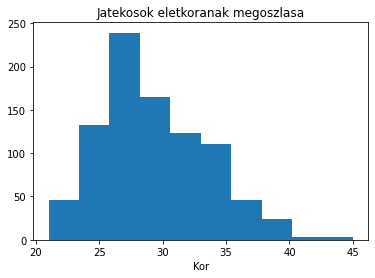

In [95]:
#Data Exploratory: Atlagos eletkor histogram
playersage = players_df[['id','currentAge']]
playersage = playersage.drop_duplicates()
playersage = playersage.drop(columns=['id'])
plt.hist(playersage)
plt.title('Jatekosok eletkoranak megoszlasa')
plt.xlabel('Kor')

In [5]:
#Uj dataframe meghatarozott ember meghatarozott esemenyeivel
sog_df = pd.DataFrame()
sog_df = events_df[events_df['eventType'].isin(['Goal'])]
sog_df = sog_df[sog_df['player1Id'].isin([8471214])]
sog_df = sog_df.drop_duplicates()

sog_df

NameError: name 'events_df' is not defined

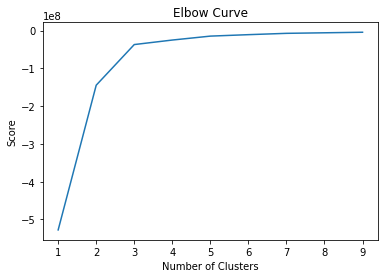

In [23]:
#Meghatarozzuk, hany klaszter erdemes letrehozni a koordinatakra (a konyokpont erteke kell nekunk, ahonnan mar
#nem novekszik tovabb lavanyosan a fgv.)
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = events_df[['coX']]
X_axis = events_df[['coY']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [4]:
#Letrehozunk egy uj dataframet a vizualizaciohoz az x es y koordinatakkal
X = sog_df.loc[:,['coX','coY']]

X_round = sog_df.loc[:,['coX','coY']]

#Uj dataframe, szamok kerekitve a masodik fajta vizualizaciohoz, hogy a szinek jol nezzenek ki:
for idx, i in X_round.iterrows():
    X_round.loc[idx,'coX'] = (round(X_round.loc[idx,'coX']/5.0)*5.0)
    X_round.loc[idx,'coY'] = (round(X_round.loc[idx,'coY']/5.0)*5.0)
#X
#X_round

NameError: name 'sog_df' is not defined

In [3]:
#A meghatarozott klaszterszamot megadva klaszterekbe soroljuk a koordinatakat
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[0:2]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[0:2]]) # Labels of each point
#X

#Kiszamoljuk a pottyok meretet, a klaszterek elemszamat vesszuk es megszorozzuk valamennyiel, hogy nagyobb legyen.
size = X.groupby(['cluster_label']).count()
size = size['coX']*30

#Ket valtozot inicializalunk aminek megadjuk az X es Y oszlopunkat, hogy kesobb be tudjuk taplalni a plot-ba
coX = X['coX']
coY = X['coY']
img = plt.imread("Half_ice_hockey_rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 100, -42.5, 42.5])
ax.scatter(coX, coY)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=size, marker='H', alpha=0.8)
plt.xlim(0,100)
plt.ylim(-42.5,42.5)
plt.show()
centers

NameError: name 'X' is not defined

In [1184]:
#Goal - Assist pairs
Y = sog_df.loc[:,['player1Id','player2Id']]
Y = Y.groupby(['player1Id', 'player2Id']).size().sort_values(ascending=False).reset_index(name='count') 
Y

,player1Id,player2Id,count
0,8471214,8474590,14
1,8471214,8475744,8
2,8471214,8473563,6
3,8471214,8475200,6
4,8471214,8476880,5
5,8471214,8471698,4
6,8471214,0,1
7,8471214,8469454,1
8,8471214,8476316,1
9,8471214,8477424,1


In [1185]:
df_counts = X_round.groupby(['coY', 'coX']).size().reset_index(name='counts')
df_counts['Number of events'] = df_counts['counts'] * 2

fig = px.scatter(df_counts, x='coX', y='coY',
                 color='Number of events',
                 size='Number of events',
                 width=685, height=580)
fig.update_layout(yaxis_range=[-42.5,42.5])
fig.update_layout(xaxis_range=[0,100])

# Remove side scale and hide zero and gridlines
fig.update_layout(
    coloraxis_showscale=True,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),)
# Disable axis ticks and labels
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')

fig.add_layout_image(
        dict(
            source='Half_ice_hockey_rink.png',
            xref="x",
            yref="y",
            x=0,
            y=42,
            sizex=100,
            sizey=85,
            sizing="stretch",
            opacity=0.5,
            layer="below")
)

fig.update_layout(template="plotly_white")

fig.show()

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3376546746.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3376546746.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3376546746.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



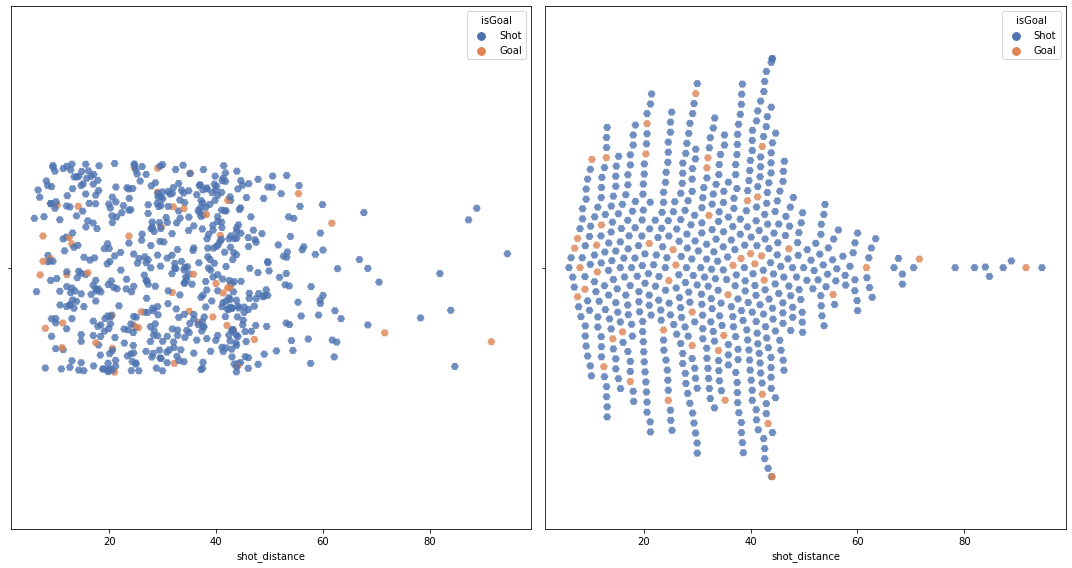

In [1196]:
dist1 = events_df[['shot_distance','player1Id','eventType']]
dist1 = dist1[dist1['eventType'].isin(['Shot','Missed Shot','Goal'])]
dist1 = dist1[dist1['player1Id'].isin([8471214])]

dist2 = events_df[['shot_distance','player2Id','eventType']]
dist2 = dist2[dist2['eventType'].isin(['Blocked Shot'])]
dist2 = dist2.rename(columns={"player2Id": "player1Id"})
dist2 = dist2[dist2['player1Id'].isin([8471214])]

dist = dist1.append(dist2, ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

dist['isGoal'] = ''

for idx, i in enumerate(dist['eventType']):
    if i == 'Goal':
        dist['isGoal'].iloc[idx] = "Goal"
    else:
        dist['isGoal'].iloc[idx] = "Shot"
        

sb.stripplot(data=dist, x=dist['shot_distance'], y=[""]*len(dist), ax=ax1, hue=dist['isGoal'],palette="deep", 
             size=8, marker="H", edgecolor="gray", alpha=.8, jitter = .2)

sb.swarmplot(data=dist, x=dist['shot_distance'], ax=ax2,  y=[""]*len(dist), hue=dist['isGoal'],palette="deep", 
             size=8, marker="H",edgecolor="gray", alpha=.8)

plt.tight_layout()

In [1180]:
#events_df.player1Type.unique() #'Winner', 'Scorer', 'Shooter', 'PenaltyOn', 'PlayerID','Blocker', 'Hitter'
#events_df.player2Type.unique() #'Loser', 'Assist', 'DrewBy', 'Goalie', 'Shooter', 'Hittee' 
    #(Blocked Shot-nal elso a Blocker masodik a Shooter)
#events_df.player3Type.unique() #'Assist', 'Goalie', 'ServedBy'
#events_df.player4Type.unique() #'Golie'
#events_df.eventType.unique()

In [1158]:
#Elso DataFrame: osszes kapuraloves a player 1-tol
tmp_sog = events_df[['gameId','player1Id','startDate','eventType']]
tmp_sog = tmp_sog[tmp_sog['eventType'].isin(['Shot','Missed Shot','Goal'])]
tmp_sog_calc = tmp_sog.groupby(['gameId','startDate','player1Id']).count()
tmp_sog_calc = tmp_sog_calc.rename(columns={"eventType": "allShots"})
tmp_sog_calc.reset_index(inplace=True)
#tmp_sog_calc

#Masodik temp dataframe: osszes kapuraloves a player 2-tol (Blocked Shot-nal player 2-n van logolva a Shooter)
tmp_sog_b = events_df[['gameId','player2Id','startDate','eventType']]
tmp_sog_b = tmp_sog_b[tmp_sog_b['eventType'].isin(['Blocked Shot'])]
tmp_sog_calc_b = tmp_sog_b.groupby(['gameId','startDate','player2Id']).count()
tmp_sog_calc_b = tmp_sog_calc_b.rename(columns={"eventType": "allShots"})
tmp_sog_calc_b.reset_index(inplace=True)
#tmp_sog_calc_b

#Harmadik temp DataFrame: Az osszes kapuraloves
tmp_allsog = pd.merge(left=tmp_sog_calc, right=tmp_sog_calc_b, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player2Id'], 
                          how='left')
tmp_allsog = tmp_allsog.fillna(0)
tmp_allsog = tmp_allsog.astype({'allShots_y': 'int64'})
tmp_allsog['allShots'] = tmp_allsog['allShots_x']+tmp_allsog['allShots_y']
tmp_allsog = tmp_allsog.drop(columns=['allShots_x','player2Id','allShots_y'])
#tmp_allsog

#Negyedik temp DataFrame: Az osszes Goal
tmp_goal = events_df[['gameId','player1Id','startDate','eventType']]
tmp_goal = tmp_goal[tmp_goal['eventType'].isin(['Goal'])]
tmp_goal_calc = tmp_goal.groupby(['gameId','startDate','player1Id']).count()
tmp_goal_calc = tmp_goal_calc.rename(columns={"eventType": "allGoals"})
tmp_goal_calc.reset_index()

#Vegso DataFrame: Osszes kapuraloves es goal merge, szazalek szamitas
sog_percentage = pd.merge(left=tmp_allsog, right=tmp_goal_calc, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player1Id'], 
                          how='left')

sog_percentage['sog%'] = round(((sog_percentage['allGoals']/sog_percentage['allShots'])*100),1)
sog_percentage["Date"] = pd.to_datetime(sog_percentage["startDate"])
sog_percentage.reset_index(inplace=True)
sog_percentage

,index,gameId,startDate,player1Id,allShots,allGoals,sog%,Date
0,0,2019020001,2019-10-02,8471676,7,1.0,14.3,2019-10-02
1,1,2019020001,2019-10-02,8473573,1,NaN,NaN,2019-10-02
2,2,2019020001,2019-10-02,8474162,4,NaN,NaN,2019-10-02
3,3,2019020001,2019-10-02,8474589,3,NaN,NaN,2019-10-02
4,4,2019020001,2019-10-02,8474697,3,NaN,NaN,2019-10-02
...,...,...,...,...,...,...,...,...
33422,33422,2019021082,2020-03-12,8480014,4,1.0,25.0,2020-03-12
33423,33423,2019021082,2020-03-12,8480113,4,NaN,NaN,2020-03-12
33424,33424,2019021082,2020-03-12,8480336,4,NaN,NaN,2020-03-12
33425,33425,2019021082,2020-03-12,8480801,5,NaN,NaN,2020-03-12


<AxesSubplot:xlabel='Date', ylabel='sog%'>

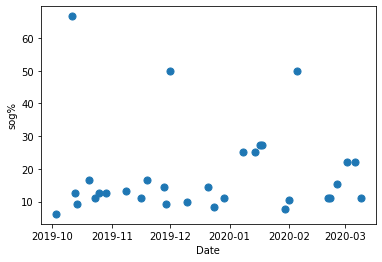

In [1164]:
#Egy jatekosra nezve:
sog_perc_oneplayer = sog_percentage[['Date','player1Id','allShots','allGoals','sog%']]
sog_perc_oneplayer = sog_perc_oneplayer[sog_perc_oneplayer['player1Id'].isin([8471214])]
sog_perc_oneplayer.plot(x='Date',y='sog%', kind='scatter',s=50)

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/1545891617.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<AxesSubplot:xlabel='periodTimeFull'>

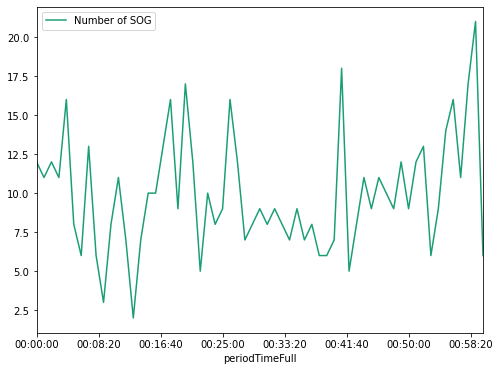

In [1160]:
#Timeline: X axis-on a 60 perc, esemenyeket percre kerekitem. A szezon osszes kapuralovese az adott percben adott embertol
#A kapuraloves lehet: 'Shot','Missed Shot','Goal' es 'Blocked Shot'. Blokkoltnal a Player2-n van logolva a Shooter

tmp_sog_time = events_df[['gameId','player1Id','startDate','eventType','periodTimeFull']]
tmp_sog_time = tmp_sog_time[tmp_sog_time['eventType'].isin(['Shot','Missed Shot','Goal'])]

tmp_sog_b_time = events_df[['gameId','player2Id','startDate','eventType','periodTimeFull']]
tmp_sog_b_time = tmp_sog_b_time[tmp_sog_b_time['eventType'].isin(['Blocked Shot'])]
tmp_sog_b_time = tmp_sog_b_time.rename(columns={"player2Id": "player1Id"})

timechart = tmp_sog_time.append(tmp_sog_b_time, ignore_index=True)

timechart = timechart[timechart['player1Id'].isin([8471214])]
timechart = timechart.groupby(['periodTimeFull']).count()
timechart = timechart.drop(columns=['gameId','player1Id','startDate'])
timechart = timechart.rename(columns={"eventType": "Number of SOG"})
timechart.reset_index(inplace=True)
timechart.plot(x='periodTimeFull', figsize=(8,6), cmap='Dark2')
#px.line(timechart, x="periodTimeFull", y="Number of SOG", title='# of SOG')
#timechart

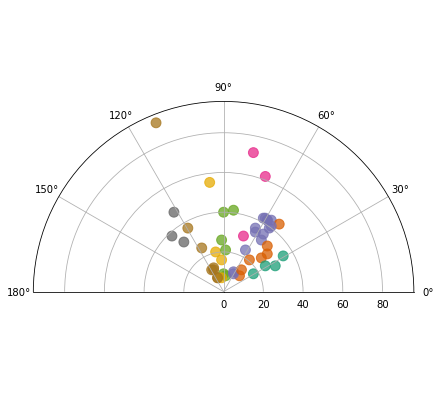

In [1151]:
#Szogek vizualizalasa
#Atszamoljuk radianra, aztan elforgatjuk hogy 0-180 kozott tudjam abrazolni
#events_df['shot_angle_rad'] = events_df['shot_angle']*(math.pi/180)
#events_df['shot_angle_vis'] = events_df['shot_angle_rad']*-1+(math.pi/2)

#Parameterek, pl Ovechkin goljai:
angledf = pd.DataFrame()
angledf = events_df[events_df['eventType'].isin(['Goal'])]
angledf = angledf[angledf['player1Id'].isin([8471214])]

theta = angledf['shot_angle_vis']
r = angledf['shot_distance']
area = angledf['shot_angle_rad'].count()
colors = theta
size = angledf['shot_angle_vis'].count()*2

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta, r, s=size, cmap='Dark2', c = colors, alpha=0.75)
plt.gcf().set_size_inches(8, 7)

ax.set_thetamin(0)
ax.set_thetamax(180)

In [1197]:
players_stat_18 = pd.read_csv('playerstats_2018.csv')
players_stat_19 = pd.read_csv('playerstats_2019.csv')

,Player,Goals_18,ixG_18,Goals_19,ixG_19
0,Connor McDavid,24,17.68,21,14.85


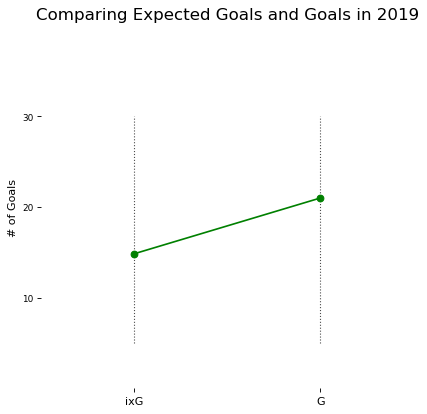

In [1293]:
name = 'Connor McDavid'

oneplayerstat_18 = players_stat_18.loc[:,['Player', 'Goals', 'ixG']]
oneplayerstat_18 = oneplayerstat_18[oneplayerstat_18['Player'] == (name)]
oneplayerstat_18 = oneplayerstat_18.rename(columns={"ixG": "ixG_18", 'Goals':'Goals_18'})
oneplayerstat_19 = players_stat_19.loc[:,['Player', 'Goals', 'ixG']]
oneplayerstat_19 = oneplayerstat_19[oneplayerstat_19['Player'] == (name)]
oneplayerstat_19 = oneplayerstat_19.rename(columns={"ixG": "ixG_19", 'Goals':'Goals_19'})

ixg = pd.merge(left=oneplayerstat_18, right=oneplayerstat_19, left_on = 'Player', right_on='Player', how='left')

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi= 80)

#Vertical lines
ax.vlines(x=1, ymin=5, ymax=30, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=5, ymax=30, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
#ax.scatter(y=ixg['Goals_18'], x=np.repeat(1, ixg.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=ixg['Goals_19'], x=np.repeat(3, ixg.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=ixg['ixG_19'], x=np.repeat(1, ixg.shape[0]), s=10, color='black', alpha=0.7)
#ax.scatter(y=ixg['Goals_18'], x=np.repeat(3, ixg.shape[0]), s=10, color='black', alpha=0.7)

# Line Segmentsand Annotation
#for p1, p2 in zip(ixg['Goals_18'], ixg['Goals_19']):
 #   newline([1,p1], [3,p2])
    
for p1, p2 in zip(ixg['ixG_19'], ixg['Goals_19']):
    newline([1,p1], [3,p2])
    
# Decoration
ax.set_title("Comparing Expected Goals and Goals in 2019", fontdict={'size':15})
ax.set(xlim=(0,4), ylim=(0,40), ylabel='# of Goals')
ax.set_xticks([1,3])
ax.set_xticklabels(["ixG", "G"])
plt.yticks((10, 20, 30), fontsize=8)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)

ixg

In [1295]:
players_stat_18.dtypes
#players_stat_19

Unnamed: 0            int64
Player               object
Team                 object
Position             object
GP                    int64
TOI                 float64
Goals                 int64
Total Assists         int64
First Assists         int64
Second Assists        int64
Total Points          int64
IPP                  object
Shots                 int64
SH%                  object
ixG                 float64
iCF                   int64
iFF                   int64
iSCF                  int64
iHDCF                 int64
Rush Attempts         int64
Rebounds Created      int64
PIM                   int64
Total Penalties       int64
Minor                 int64
Major                 int64
Misconduct            int64
Penalties Drawn       int64
Giveaways             int64
Takeaways             int64
Hits                  int64
Hits Taken            int64
Shots Blocked         int64
Faceoffs Won          int64
Faceoffs Lost         int64
Faceoffs %           object
dtype: object

In [ ]:
events_df['TMP_periodTimeFull'] = ''

for idx, i in enumerate(events_df['TMP_periodTimeFull']):
    events_df['TMP_periodTimeFull'].iloc[idx] = (events_df['periodTimeFull'].iloc[idx])+((events_df['period'].iloc[idx]-1)*pd.to_timedelta('00:20:00'))

events_df

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/23841731.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
events_df.head()

In [1328]:

#events_df['TMP_periodTimeFull'] = ''
#events_df['TMP_periodTimeFull']  = events_df['periodTimeFull'] + ((events_df['period']-1) * pd.to_timedelta('00:20:00'))
events_df[200:]
#print((events_df['period']-1))

,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,player2Type,player3Id,player3Type,player4Id,player4Type,startDate,periodTimeFull,shot_angle,shot_distance,TMP_periodTimeFull
200,2019020001,199,Missed Shot,Brady Tkachuk Over Net,2,10:40,REGULAR,9,10,3,...,0,0,0,0,0,2019-10-02,0 days 00:10:40,8.130102,7.071068,0 days 00:30:40
201,2019020001,201,Faceoff,Chris Tierney faceoff won against Frederik Gau...,2,10:40,REGULAR,9,10,3,...,Loser,0,0,0,0,2019-10-02,0 days 00:10:40,47.726311,29.732137,0 days 00:30:40
202,2019020001,202,Missed Shot,Ilya Mikheyev Wide of Net,2,10:47,REGULAR,9,10,3,...,0,0,0,0,0,2019-10-02,0 days 00:10:47,18.741340,59.135438,0 days 00:30:47
203,2019020001,203,Stoppage,Offside,2,12:09,REGULAR,9,10,3,...,0,0,0,0,0,2019-10-02,0 days 00:12:09,0.000000,89.000000,0 days 00:32:09
204,2019020001,204,Faceoff,Auston Matthews faceoff won against Jean-Gabri...,2,12:09,REGULAR,9,10,3,...,Loser,0,0,0,0,2019-10-02,0 days 00:12:09,-17.684392,72.422372,0 days 00:32:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342985,2019021082,303,Blocked Shot,Martin Frk shot blocked shot by Anthony Duclair,3,19:47,REGULAR,9,26,3,...,Shooter,0,0,0,0,2020-03-12,0 days 00:19:47,35.394796,46.615448,0 days 00:59:47
342986,2019021082,304,Period End,End of 3rd Period,3,20:00,REGULAR,9,26,3,...,0,0,0,0,0,2020-03-12,0 days 00:20:00,0.000000,89.000000,0 days 01:00:00
342987,2019021082,305,Period Official,Period Official,3,20:00,REGULAR,9,26,3,...,0,0,0,0,0,2020-03-12,0 days 00:20:00,0.000000,89.000000,0 days 01:00:00
342988,2019021082,306,Game End,Game End,3,20:00,REGULAR,9,26,3,...,0,0,0,0,0,2020-03-12,0 days 00:20:00,0.000000,89.000000,0 days 01:00:00
